In [3]:
from __future__ import print_function, division
import os
from os import walk
import sys
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import tqdm
import re

In [14]:
!pip install tqdm


In [5]:
PATH = 'Rice Seed Dataset' # Path of the dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    
all_best_accs = []

In [18]:
available_models = ["vgg"]

def set_parameter_requires_grad(model, feature_extracting): #function to freezing parameters in our model
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes = 2, feature_extract = True, use_pretrained=True): # num_classes=3 
                                                                                                #since we have 3 classes
    
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    
    model_name = model_name.lower() 
    model_name.replace(" ", "") # removing spaces in string
    model_name = re.sub(r'[0-9]',"",model_name) # removing numbers in string
    
    
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_name = "Resnet18"
        model_ft = models.resnet18(pretrained=use_pretrained) # using pretrained weights
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)   # setting number of outputs to 3 (initially most models have number of 
                                                         #  outputs as 1000 since they are trained on imagenet)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_name = "Alexnet"
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16_bn
        """
        model_name = "VGG16 with batch normalization"
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_name = "Squeezenet"
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_name = "Densenet"
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has two outputs normal output and auxiliary output
        """
        model_name = "Inception v3"
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    model_ft = model_ft.to(device)
    return model_ft, input_size

In [19]:
# available_models = ["resnet","alexnet","vgg","squeezenet","densenet","inception"]
model_name = "inception"
model, size = initialize_model(model_name)
print("model =",model_name,"\nsize of image = "+ str(size)) # optimal size of the image to be given input

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\visal Adikari/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100.0%


model = inception 
size of image = 299


In [20]:
data_dir = PATH 
batch_size = 32
valid_size = 0.1 # define partition of validation size in train size

# Defining transforms for the training data and testing data
data_transforms = transforms.Compose([transforms.RandomAffine(degrees = [0,9], shear = [0., 0.066, 0.133, 0.2]),
                                       transforms.Resize((size,size)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])


# obtain training indices that will be used for validation
data = datasets.ImageFolder(data_dir , transform= data_transforms)
dataset_sizes = {"train" : (len(data)*9)//10, "val" : len(data)//10}
num_train = len(data)

indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=valid_sampler)
data_loader = {"train" : train_loader, "val" : val_loader}
phases = ["train", "val"]
class_names = data.classes

print("The Classes are : ",end = "")
print(*class_names,sep = ", ")

The Classes are : Healthy_Images, Unhealthy_Images


torch.Size([3, 299, 299])


<Axes: >

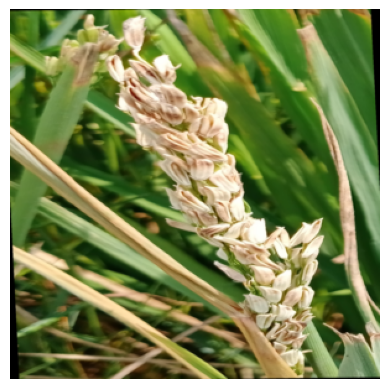

In [21]:
def imshow1(image, ax=None, title=None, normalize=True):
    #Imshow for Tensor
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0., 0., 0.])
        std = np.array([1., 1., 1.])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

data_iter = iter(val_loader)

images, labels = next(data_iter)
print(images[0].shape)
imshow1(images[0])

In [22]:
def train_model(model, criterion, optimizer, scheduler, epochs= 3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch, (inputs, labels) in enumerate(data_loader[phase]):
                print("\r batch {}/{}".format(batch+1, len(data_loader[phase])), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if model_name == "inception" and phase == "train": # Will only run for incepton training
                        outputs,aux = model(inputs)
                    else:
                        outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if model_name == "inception" and phase == "train": # Will only run for incepton training
                        loss = criterion(outputs,labels) + 0.4*criterion(aux,labels)
                    else:
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    all_best_accs.append(best_acc)
    return model

In [23]:
model = {x:[] for x in available_models}

begin_tol = time.time()

for model_name in available_models:
    
    # ----------------> Initialization part
    model[model_name], size = initialize_model(model_name)
    
    
    # ----------------> Data loader part
    data_dir = PATH
    batch_size = 32
    valid_size = 0.1 # define partition of validation size in train size

    # TODO: Define transforms for the training data and testing data
    train_transforms = transforms.Compose([transforms.RandomAffine(degrees = [0,9], shear = [0., 0.066, 0.133, 0.2]),
                                           transforms.Resize((size,size)),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor()])


    # obtain training indices that will be used for validation
    data = datasets.ImageFolder(data_dir , transform=train_transforms)
    dataset_sizes = {"train" : (len(data)*9)//10, "val" : len(data)//10}
    num_train = len(data)

    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))

    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=valid_sampler)
    data_loader = {"train" : train_loader, "val" : val_loader}
    modes = ["train", "val"]
    class_names = data.classes    
    
    # ----------------> Training part    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model[model_name].parameters(), lr = 0.01, momentum = 0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
    
    print("\n"+"\033[1m" + model_name.upper() + "\033[0m")
    
    train_model(model[model_name], criterion, optimizer, exp_lr_scheduler, epochs = 3)
    torch.save(model[model_name].state_dict(), model_name+'_covid_xray.pt')

    
 # We get the total time for training of all the models    
tol_time = time.time()-begin_tol 
print('Total training completed in {:.0f}m {:.0f}s'.format(tol_time // 60, tol_time % 60))

# Finding the best model on the validation set
overall_best_acc = max(all_best_accs)
best_model_name = available_models[all_best_accs.index(overall_best_acc)]
print("best model is "+best_model_name.upper()+" with accuracy of "+str(overall_best_acc.item()*100)[:6]+" %")

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\visal Adikari/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth
100.0%



VGG
Epoch 1/3
----------
 batch 29/29
train Loss: 0.5376 Acc: 0.7506
 batch 4/4
val Loss: 0.4540 Acc: 0.8300

Epoch 2/3
----------
 batch 29/29
train Loss: 0.4155 Acc: 0.8278
 batch 4/4
val Loss: 0.3000 Acc: 0.8400

Epoch 3/3
----------
 batch 29/29
train Loss: 0.5575 Acc: 0.7914
 batch 4/4
val Loss: 0.4967 Acc: 0.8100

Training complete in 10m 42s
Best val Acc: 0.840000
Total training completed in 16m 42s
best model is VGG with accuracy of 84.0 %


In [24]:
all_best_accs_test = []
def test_model(model, criterion, optimizer, scheduler, epochs= 3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print('-' * 10)
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for batch, (inputs, labels) in enumerate(data_loader):
        print("\rbatch {}/{}".format(batch+1, len(data_loader)), end='', flush=True)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

#                 if batch == 3:
#                     break

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size
        phase = "test"
    print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
    best_acc = epoch_acc
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    all_best_accs_test.append(best_acc)

In [25]:
model_c = {x:[] for x in available_models}
begin_tol = time.time()
for model_name in available_models:
    
    model_c[model_name], size = initialize_model(model_name)
    model_c[model_name].load_state_dict(torch.load("./"+model_name+"_covid_xray.pt"))
    data_dir = PATH
    batch_size = 32
    valid_size = 0.1 # define partition of validation size in train size

    # TODO: Define transforms for the training data and testing data
    train_transforms = transforms.Compose([transforms.RandomAffine(degrees = [0,9], shear = [0., 0.066, 0.133, 0.2]),
                                           transforms.Resize((size,size)),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor()])


    # obtain training indices that will be used for validation
    data = datasets.ImageFolder(data_dir , transform=train_transforms)
    dataset_size = len(data)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)

    class_names = data.classes    
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_c[model_name].parameters(), lr = 0.01, momentum = 0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
    print("\n"+"\033[1m" + model_name.upper() + "\033[0m")
    test_model(model_c[model_name], criterion, optimizer, exp_lr_scheduler, epochs = 3)


tol_time = time.time()-begin_tol
print('Total testing completed in {:.0f}m {:.0f}s'.format(tol_time // 60, tol_time % 60))
overall_best_acc = max(all_best_accs_test)
best_model_name = available_models[all_best_accs_test.index(overall_best_acc)]

print("best model is "+best_model_name.upper()+" with accuracy of "+str(overall_best_acc.item()*100)[:6]+" %")


VGG
----------
batch 32/32
test Loss: 0.3055 Acc: 0.8729

Training complete in 3m 51s
Best val Acc: 0.872890
Total testing completed in 3m 54s
best model is VGG with accuracy of 87.288 %
